# eQTL analysis and multiple traits

This tutorial illustrates the use of LIMIX to anlayse expression datasets. For this illustration, we consider gene expression levels from a yeast genetics study with freely available data <cite data-cite="smith2008gene">(Smith & Kruglyak, 2008)</cite>.
These data span 109 individuals with 2,956 marker SNPs and expression levels for 5,493 in glucose and ethanol growth media respectively.

We start out by discussing how to do QTL mapping, implement models that consider multi loci and introduce the application of variance component models for single quantitative traits. 
Subsequently, these analysis are extended to the corresponding multi-trait models, combining the corresponding quantitative traits across both enviornment or multiple genes in a pathway.
Finally, we show how LIMIX can be used to fit variance component models that account for gene expression heteorgeneity by fitting a suitale covariance matrix.

# Setting up

In [1]:
# activate inline plotting
%matplotlib inline

In [2]:
from setup import *

In [3]:
#import data
#the data used in this study have been pre-converted into an hdf5 file. 
#to preprocess your own data, please use limix command line brinary
file_name = tutorial_data.get_file('smith08')
geno_reader  = gr.genotype_reader_tables(file_name)
pheno_reader = phr.pheno_reader_tables(file_name)

#the data object allows to query specific genotype or phenotype data
dataset = data.QTLData(geno_reader=geno_reader,pheno_reader=pheno_reader)
#getting genotypes
snps = dataset.getGenotypes() #SNPs
position = dataset.getPos()
position,chromBounds = data_util.estCumPos(position=position,offset=100000)

# non-normalized and normalized sample relatedeness matrix
sample_relatedness_unnormalized = dataset.getCovariance(normalize=False)
sample_relatedness  = sample_relatedness_unnormalized/ \
    sample_relatedness_unnormalized.diagonal().mean()

In [4]:
#genes from lysine biosynthesis pathway
lysine_group = ['YIL094C', 'YDL182W', 'YDL131W', 'YER052C', 'YBR115C', 'YDR158W',
                'YNR050C', 'YJR139C', 'YIR034C', 'YGL202W', 'YDR234W']

[]

/Users/davis/anaconda/envs/py2.7/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


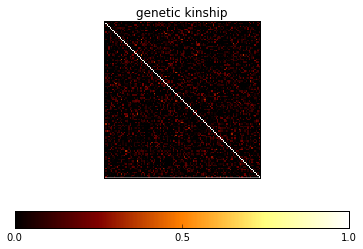

In [5]:
# plot (genetic) sample relatedeness matrix
plt = pl.subplot(1,1,1)
pl.title('genetic kinship')
pl.imshow(sample_relatedness,vmin=0,vmax=1,interpolation='none',cmap=cm.afmhot)
pl.colorbar(ticks=[0,0.5,1],orientation='horizontal')
plt.set_xticks([])
plt.set_yticks([])

# Single Trait Analysis

## Marginal single Locus Analysis

### The Genetic Model

Indicating with $N$ the number of samples,
the standard LMM considered by LIMIX is
\begin{equation}
\mathbf{y} = \mathbf{F}\boldsymbol{\alpha} + \mathbf{x}\beta + \mathbf{g}+\boldsymbol{\psi},\;\;\;
\mathbf{g}\sim\mathcal{N}\left(\mathbf{0},\sigma_g^2\mathbf{R}\right),\;
\boldsymbol{\psi}\sim\mathcal{N}\left(\mathbf{0},\sigma_e^2\mathbf{I}_N\right)
\end{equation}
where
\begin{eqnarray}
\mathbf{y}   &=& \text{phenotype vector} \in \mathcal{R}^{N,1} \\
\mathbf{F}   &=& \text{matrix of $K$ covariates} \in \mathcal{R}^{N,K} \\
\boldsymbol{\alpha} &=& \text{effect of covariates} \in \mathcal{R}^{K,1} \\
\mathbf{x}   &=& \text{genetic profile of the SNP being tested} \in \mathcal{R}^{N,1} \\
\boldsymbol{\beta}   &=& \text{effect size of the SNP} \in \mathcal{R} \\
\mathbf{g}   &=& \text{polygenic effect from all SNPs} \in \mathcal{R}^{N,1} \\
\mathbf{R}   &=& \text{sample relatedeness matrix} \in \mathcal{R}^{N,N} \\
\end{eqnarray}
Association between phenotypic changes and the genetic markers is tested by testing $\beta\neq0$.

The model can be rewritten using the delta-representation
\begin{equation}
\mathbf{y}\sim
\mathcal{N}\left(\mathbf{W}\boldsymbol{\alpha}+\mathbf{x}\beta,
\sigma_g^2\left(\mathbf{R}+\delta\mathbf{I}\right)\right)
\end{equation}
where $\delta={\sigma_e^2}/{\sigma_g^2}$ is the signal-to-noise ratio, which can be efficiently fit for every genome wide test (parameter searchDelta). For efficient inference, LIMIX uses the identical speedups to those implemented in <cite data-cite="lippert2011fast">(Lippert et al., 2011)</cite> and GEMMA <cite data-cite="zhou2012genome">(Stephens et al., 2012)</cite>.

### Example: Single-trait eQTL mapping for gene YBR115C in the glucose condition

In [6]:
#create a complex query on the gene_ID and environment:
# select environment 0 (glucose) for gene YBR115C
phenotype_query = "(gene_ID=='YBR115C') & (environment==0)"

# getting the appropriate data subset
data_subsample = dataset.subsample_phenotypes(phenotype_query=phenotype_query,
                                           intersection=True)

#get variables we need from data
snps = data_subsample.getGenotypes(impute_missing=True)
phenotypes,sample_idx = data_subsample.getPhenotypes(phenotype_query=phenotype_query,
                                                     intersection=True); 
assert sample_idx.all()

#set parameters for the analysis
N, P = phenotypes.shape 
S    = snps.shape[1]

print "loaded %d samples, %d phenotypes, %s snps" % (N,P,S)

covs = None                 #covariates
searchDelta = False         #specify if delta should be optimized for each SNP
test="lrt"                  #specify type of statistical test

# Running the analysis
# when cov are not set (None), LIMIX considers an intercept (covs=SP.ones((N,1)))
lmm = qtl.test_lmm(snps=snps,pheno=phenotypes.values,
                   K=sample_relatedness,covs=covs, test=test)

pvalues = lmm.getPv()       # 1xS vector of p-values (S=X.shape[1])
#convert P-values to a DataFrame for nice output writing:
pvalues = pd.DataFrame(data=pvalues.T,index=data_subsample.geno_ID,
                       columns=phenotypes.columns)

betas = lmm.getBetaSNP()    # 1xS vector of effect sizes (S=X.shape[1])
#convert betas to a DataFrame for nice output writing:
betas = pd.DataFrame(data=betas.T,index=data_subsample.geno_ID,
                     columns=phenotypes.columns)

loaded 109 samples, 1 phenotypes, 2956 snps


#### Get Position of the gene

In [7]:
gene_start = data_subsample.pheno_reader.get_pos(phenotype_query)['start']
Ichrom = (position['chrom'].values==(gene_start[0,0]-1))
gene_pos_cum = position['pos_cum'][Ichrom].max()+gene_start[0,1]

#### Make Manhattan Plot

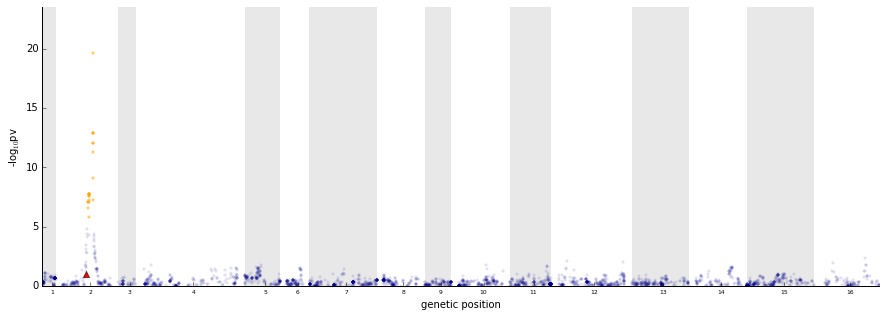

In [8]:
pl.figure(figsize=[15,5])
plot_manhattan(position['pos_cum'],pvalues['YBR115C:0'],chromBounds)
pl.plot(gene_pos_cum,1,'^r')

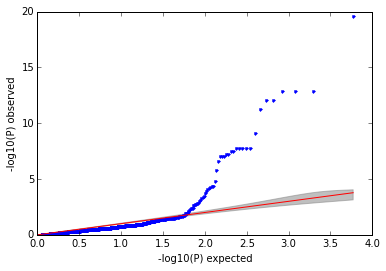

In [9]:
qqplot(pvalues['YBR115C:0'])

## Cis eQTL mapping

In [10]:
#create a complex query on the gene_ID and environment:
# select environment 0 (glucose) for gene YBR115C
phenotype_query = "(gene_ID=='YBR115C') & (environment==0)"

# getting the appropriate data subset
data_subsample = dataset.subsample_phenotypes(phenotype_query=phenotype_query,
                                           intersection=True)

In [11]:
windowsize = 5e5
pos_gene = data_subsample.pheno_reader.get_pos(phenotype_query)
data_subsample_cis = data_subsample.subsample(chrom=pos_gene["start"][0,0],pos_start=pos_gene["start"][0],
                                        pos_end=pos_gene["end"][0],windowsize=windowsize)
snps_cis = data_subsample_cis.getGenotypes()
position_cis = data_subsample_cis.getPos()

/Users/davis/anaconda/envs/py2.7/lib/python2.7/site-packages/limix/io/data.py:196: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if not (idx_start==None and idx_end==None and pos_start==None and pos_end==None and chrom==None):
/Users/davis/anaconda/envs/py2.7/lib/python2.7/site-packages/limix/io/data.py:45: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if idx_start==None and idx_end==None and pos_start==None and pos_end==None and chrom==None:


In [12]:
phenotypes,sample_idx = data_subsample.getPhenotypes(phenotype_query=phenotype_query,
                                                     intersection=True); 
assert sample_idx.all()

#set parameters for the analysis
N, P = phenotypes.shape 
S    = snps_cis.shape[1]

print "loaded %d samples, %d phenotypes, %s snps" % (N,P,S)

covs = None                 #covariates
searchDelta = False         #specify if delta should be optimized for each SNP
test="lrt"                  #specify type of statistical test

# Running the analysis
# when cov are not set (None), LIMIX considers an intercept (covs=SP.ones((N,1)))
lmm = qtl.test_lmm(snps=snps_cis,pheno=phenotypes.values,
                   K=sample_relatedness,covs=covs, test=test)

pvalues_cis = lmm.getPv()       # 1xS vector of p-values (S=X.shape[1])


loaded 109 samples, 1 phenotypes, 188 snps


In [13]:
#convert P-values to a DataFrame for nice output writing:
pvalues_cis = pd.DataFrame(data=pvalues_cis.T,index=data_subsample_cis.geno_ID,
                       columns=phenotypes.columns)

betas_cis = lmm.getBetaSNP()    # 1xS vector of effect sizes (S=X.shape[1])
#convert betas to a DataFrame for nice output writing:
betas_cis = pd.DataFrame(data=betas.T,index=data_subsample_cis.geno_ID,
                     columns=phenotypes.columns)

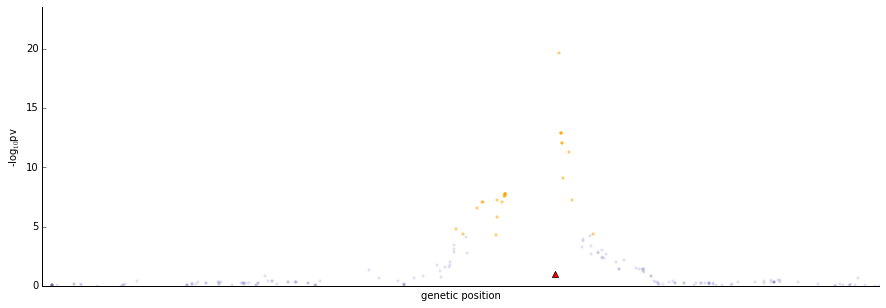

In [14]:
pl.figure(figsize=[15,5])
plot_manhattan(position_cis['pos'],pvalues_cis['YBR115C:0'])
pl.plot([pos_gene["start"][0,1],pos_gene["end"][0,1]],[1,1],'^r')

In [15]:
idx = pvalues_cis['YBR115C:0'].values.argmin()
print position_cis['pos'].values[idx]
print 's02-477240'

477206
s02-477240


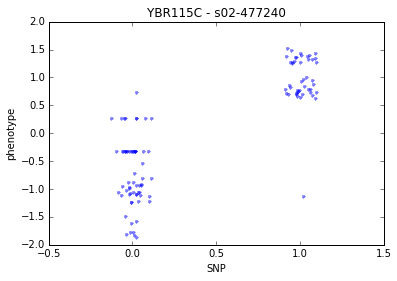

In [16]:
pl.plot(snps_cis[:,idx]+0.05*np.random.randn(snps[:,idx].shape[0]),phenotypes.values,'.',alpha=0.5)
pl.xlabel("SNP")
pl.ylabel("phenotype")
pl.xlim([-0.5,1.5])
pl.title("YBR115C - s02-477240")

### Example: Single-trait eQTL mapping for all genes in the pathways in the glucose condition

In [17]:
#create a complex query on the gene_ID and environment:
# select environment 0 for all genes in lysine_group
phenotype_query = "(gene_ID in %s) & (environment==0)" % str(lysine_group)

data_subsample = dataset.subsample_phenotypes(phenotype_query=phenotype_query,
                                           intersection=True)

#get variables we need from data
snps = data_subsample.getGenotypes(impute_missing=True)
phenotypes,sample_idx = data_subsample.getPhenotypes(phenotype_query=phenotype_query,
                                                     intersection=True)
assert sample_idx.all()

sample_relatedness = data_subsample.getCovariance()

#set parameters for the analysis
N, P = phenotypes.shape
S    = snps.shape[1]

print "loaded %d samples, %d phenotypes, %s snps" % (N,P,S)

covs = None                 #covariates
searchDelta = False         #specify if delta is optimized for each SNP
test="lrt"                  #specify type of statistical test

# Running the analysis
# when cov are not set (None), LIMIX considers an intercept 
# (covs=SP.ones((N,1))) note, as phenotypes is a matrix, 
# LIMIX automatically carries out an association scan for each phenotype
lmm = qtl.test_lmm(snps=snps,pheno=phenotypes.values,
                   K=sample_relatedness,covs=covs,test=test)

# get p-values
pvalues = lmm.getPv()       # 1xS vector of p-values (S=X.shape[1])
#convert P-values to a DataFrame for nice output writing:
pvalues = pd.DataFrame(data=pvalues.T,index=data_subsample.geno_ID,
                       columns=phenotypes.columns)
betas = lmm.getBetaSNP()    # 1xS vector of effect sizes (S=X.shape[1])
#convert betas to a DataFrame for nice output writing:
betas = pd.DataFrame(data=betas.T,index=data_subsample.geno_ID,
                     columns=phenotypes.columns)

loaded 109 samples, 11 phenotypes, 2956 snps


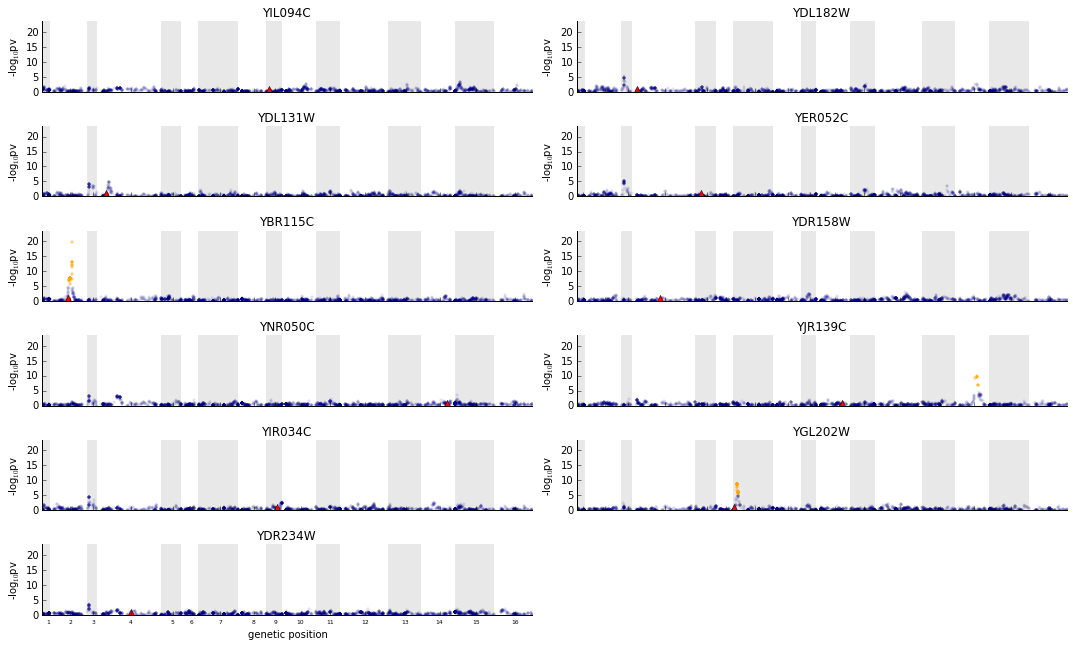

In [18]:
# plotting all manhattan plots
pl.figure(1,figsize=(15,16))
lim = -1.2*sp.log10(lmm.getPv().min())
for g in range(P):
    plt = pl.subplot(P,2,g+1)
    pl.title(lysine_group[g])
    if g!=P-1:   xticklabels = False
    else:        xticklabels = True
    plot_manhattan(position['pos_cum'],pvalues[lysine_group[g]+":0"],
                   chromBounds,lim=lim,xticklabels=xticklabels)
    phenotype_query = "(gene_ID=='%s') & (environment==0)"%lysine_group[g]
    gene_start = data_subsample.pheno_reader.get_pos(phenotype_query)['start']
    Ichrom = (position['chrom'].values==(gene_start[0,0]-1))
    gene_pos_cum = position['pos_cum'][Ichrom].max()+gene_start[0,1]
    pl.plot(gene_pos_cum,1,'^r')
pl.tight_layout()

## Chromosomal Scan

In [19]:
#create a complex query on the gene_ID and environment:
# select environment 0 (glucose) for gene YBR115C
phenotype_query = "(gene_chrom=='2') & (environment==0)"

# getting the appropriate data subset
data_subsample_chrom = dataset.subsample_phenotypes(phenotype_query=phenotype_query,
                                           intersection=True)
data_subsample_chrom = data_subsample_chrom.subsample(chrom=2)

In [20]:
#get variables we need from data
snps_chrom = data_subsample_chrom.getGenotypes(impute_missing=True)
phenotypes_chrom,sample_idx = data_subsample_chrom.getPhenotypes(phenotype_query=phenotype_query,
                                                             intersection=True)
assert sample_idx.all()

#set parameters for the analysis
N, P = phenotypes_chrom.shape
S    = snps_chrom.shape[1]

print "loaded %d samples, %d phenotypes, %s snps" % (N,P,S)

loaded 109 samples, 388 phenotypes, 188 snps


In [21]:
covs = None                 #covariates
searchDelta = False         #specify if delta is optimized for each SNP
test="lrt"                  #specify type of statistical test

# Running the analysis
# when cov are not set (None), LIMIX considers an intercept 
# (covs=SP.ones((N,1))) note, as phenotypes is a matrix, 
# LIMIX automatically carries out an association scan for each phenotype
lmm = qtl.test_lmm(snps=snps_chrom,pheno=phenotypes_chrom.values,
                   K=sample_relatedness,covs=covs,test=test)

# get p-values
pvalues = lmm.getPv()       # 1xS vector of p-values (S=X.shape[1])

In [22]:
Isign = (pvalues<(1e-2)/float(pvalues.size)) # Bonferroni corrected significance 1%
idx_gene_significant,idx_pos_significant = sp.where(Isign)

position_chrom = data_subsample_chrom.getPos()
pos_gene_chrom = data_subsample_chrom.pheno_reader.get_pos(phenotype_query)

In [23]:
sign_position_chrom = position_chrom['pos'].values[idx_pos_significant]
sign_pos_gene_chrom = pos_gene_chrom['start'][:,1][idx_gene_significant]

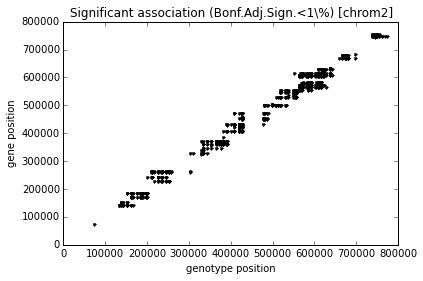

In [24]:
pl.plot(sign_position_chrom,sign_pos_gene_chrom,'.k')
pl.xlabel('genotype position')
pl.ylabel('gene position')
pl.title('Significant association (Bonf.Adj.Sign.<1\%) [chrom2]')

## GxE interactions and common effects

For a specifc effect test for trait $p$
the alternative model is set to have both a common and a specific effect
for transcript $p$ from the SNP while the null model has only a common effect.

It is a 1 degree of freedom test and,
in the particular case of $P=3$ traits and for $p=0$, it can be done by setting
\begin{equation}
\mathbf{A}_1^\text{(snp)} =
\begin{pmatrix}
  1 & 0 & 0 \\
  1 & 1 & 1
 \end{pmatrix}
\;\;\;,
\mathbf{A}_0^\text{(snp)} = \mathbf{1}_{1,3}
\end{equation}

#### Example: specific effect test for gene YJR139C across environments

In [25]:
#['YFL027C' 'YGL035C' 'YGL119W' 'YGR289C' 'YBR045C' 'YBR026C' 'YOR028C'
# 'YFR055W' 'YHR054C' 'YHR054C']

# select all environmens for gene YJR139C in lysine_group
#phenotype_query = "(gene_ID == 'YGR256W')"
phenotype_query = "(gene_ID == 'YGL035C')"

data_subsample = dataset.subsample_phenotypes(phenotype_query=phenotype_query,
                                           intersection=True)

#get variables we need from data
snps = data_subsample.getGenotypes(impute_missing=True)
phenotypes,sample_idx = data_subsample.getPhenotypes(phenotype_query=phenotype_query,
                                                     intersection=True) 
assert sample_idx.all()

sample_relatedness = data_subsample.getCovariance()

#set parameters for the analysis
N, P = phenotypes.shape   

covs = None                 #covariates
Acovs = None                #the design matrix for the covariates   
Asnps0 = sp.ones((1,P))     #the null model design matrix for the SNPs
Asnps1 = sp.zeros((2,P))    #the alternative model design matrix for the SNPs
Asnps1[0,:] = 1.0           
Asnps1[1,0] = 1.0       
K1r = sample_relatedness    #the first sample-sample covariance matrix (non-noise)
K2r = sp.eye(N)             #the second sample-sample covariance matrix (noise)
K1c = None                  #the first phenotype-phenotype covariance matrix (non-noise)
K2c = None                  #the second phenotype-phenotype covariance matrix (noise)
covar_type = 'freeform'     #the type of the trait/trait covariance to be estimated 
searchDelta = False         #specify if delta should be optimized for each SNP
test="lrt"                  #specify type of statistical test

# Running the analysis
# when cov are not set (None), LIMIX considers an intercept (covs=SP.ones((N,1)))
pvalues = qtl.test_interaction_lmm_kronecker(snps=snps,phenos=phenotypes.values,
    covs=covs,Acovs=Acovs,Asnps1=Asnps1,Asnps0=Asnps0,K1r=K1r,K2r=K2r,K1c=K1c,K2c=K2c,
    trait_covar_type=covar_type,searchDelta=searchDelta)


#convert P-values to a DataFrame for nice output writing:
pvalues = pd.DataFrame(data=sp.concatenate(pvalues).T,index=data_subsample.geno_ID,
                       columns=["specific","common","any"])

.. Training the backgrond covariance with a GP model
Background model trained in 0.24 s


/Users/davis/anaconda/envs/py2.7/lib/python2.7/site-packages/limix/modules/qtl.py:373: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if K1r==None:
/Users/davis/anaconda/envs/py2.7/lib/python2.7/site-packages/limix/modules/qtl.py:379: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if K2r==None:


Simple_interaction_kronecker not only compares the alternative model (where the trait design of the SNP is Asnp=Asnp1)
versus the null model (where the trait design of the SNP is Asnp=Asnp0) but also compares
the alternative model and the null models versus the no association model (Asnp=0).
Three pvalues are then retured:
- pv for alternative vs null (specific effect test)
- pv for null vs noAssociation (common effect test)
- pv for alternative vs noAssociation (any effect test)

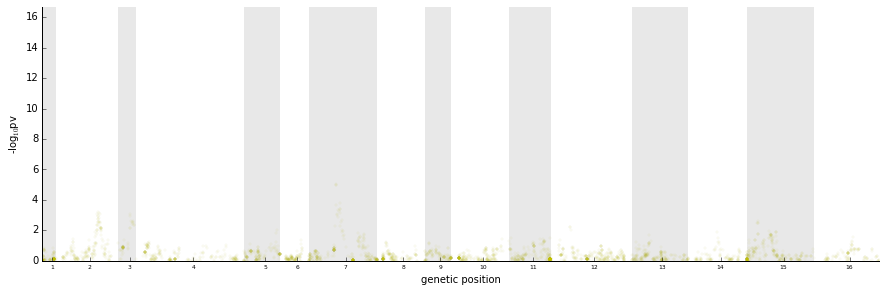

In [27]:
tests = ['Any effect test','Interaction effect test']
lim = -1.2*sp.log10(sp.array([pvalues['common'].min(),pvalues['specific'].min()]).min())
pl.figure(figsize=[15,10])
plt = pl.subplot(2,1,1)
plot_manhattan(position['pos_cum'],pvalues['common'],
               chromBounds,colorS='y',colorNS='y',lim=lim,alphaNS=0.05)

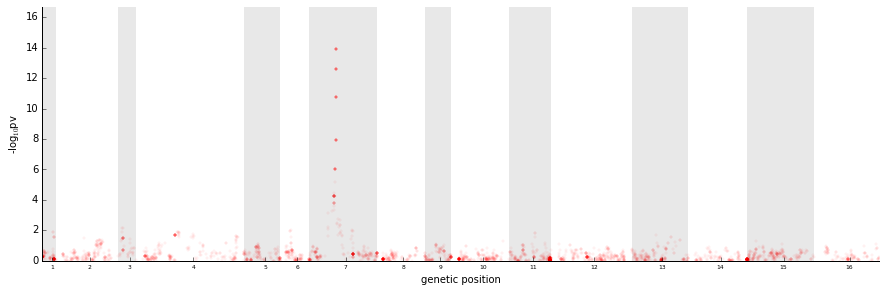

In [29]:
pl.figure(figsize=[15,10])
plt = pl.subplot(2,1,1)
plot_manhattan(position['pos_cum'],pvalues['specific'],
               chromBounds,colorS='r',colorNS='r',lim=lim,alphaNS=0.05)

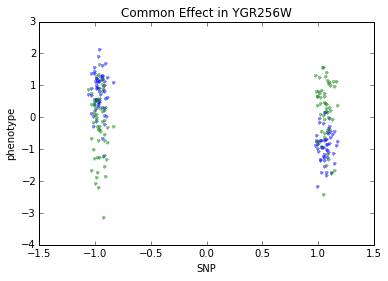

In [30]:
idx = pvalues['specific'].argmin()
pl.title('Common Effect in YGR256W')
pl.plot(snps[:,idx]+0.05*np.random.randn(snps[:,idx].shape[0]),phenotypes.values,'.',alpha=0.5)
pl.xlabel("SNP")
pl.ylabel("phenotype")

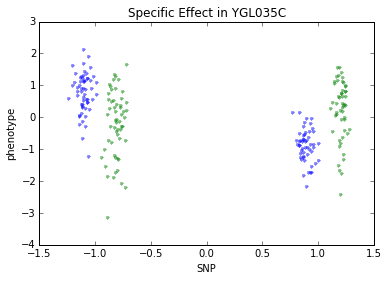

In [31]:
idx = pvalues['specific'].argmin()
pl.title('Specific Effect in YGL035C')
pl.plot(snps[:,idx]+0.05*np.random.randn(snps[:,idx].shape[0])-0.15,phenotypes.values[:,0],'.',alpha=0.5)
pl.plot(snps[:,idx]+0.05*np.random.randn(snps[:,idx].shape[0])+0.15,phenotypes.values[:,1],'.',alpha=0.5)
pl.xlabel("SNP")
pl.ylabel("phenotype")